# Comparative Analysis of BERT Model Variants for Author Classification in English Literature

Authorship classification, or figuring out who wrote a piece of writing, is an important part of jobs like finding plagiarism, analyzing literature, and making sure the author is who they say they are. In the past, figuring out who wrote something relied on stylometric analysis, which looked at things like word choice, sentence length, and punctuation using statistics. But the rise of deep learning models, especially transformers, has changed this job by better understanding how things relate to each other in context.

The BERT model, which stands for "Bidirectional Encoder Representations from Transformers," has the best success in NLP tasks right now. There are three types of BERT that we are comparing in this project for author classification:

    Base BERT: Standard-sized model with 110M parameters.
    DistilBERT: A lightweight version with 66M parameters.
    Large BERT: A high-parameter model with 340M parameters for superior accuracy.


## Imports and Dataset


We used the Gutenberg Project dataset, focusing on main authors from the 18th century. Initially, we tried using whole books as rows but faced problems due to BERT's sequence length limit. Our final strategy was to split books into sections of up to 420 words, increasing data points per author while maintaining manageable sequence lengths.

In [ ]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# Import dataset
data = pd.read_csv('poetry-dataset.csv')

data.head()

,Unnamed: 0,gid,content,author,title,author_birth
0,0,19,The Song of Hiawatha is based on the legends a...,John Milton,Paradise Lost,1608
1,1,20,"Of that Forbidden Tree, whose mortal tast\nBro...",Aesop,Aesop's Fables\tTranslated by George Fyler Tow...,-620
2,2,26,"Of Man's first disobedience, and the fruit\nOf...",Thomas Hardy,Far from the Madding Crowd,1840
3,3,58,"I, WHO erewhile the happy Garden sung\nBy one ...",Friedrich Engels,The Communist Manifesto,1820
4,4,109,All I could see from where I stood\nThe room i...,Richard McGowan,Violists,1958


## Preprocessing:

The dataset is currently formatted with one row per book, where the content column contains the entire book's text. In earlier project versions, we experimented with splitting the data differently. When feeding the BERT models line by line, performance was poor (training accuracy ~20%). We concluded that a single line, often limited to 18 words and lacking complete sentences, did not provide enough context for the model to learn the authors' styles. Ultimately, we opted to divide the books into larger sections for better results.

In [ ]:
# Function for splitting the book into chunks
def split_content(row, chunk_size=2000): # chunk_size here refers to number of characters
    content = row['content']
    chunks = [content[i:i+chunk_size] for i in range(0, len(content), chunk_size)]
    return pd.DataFrame({'author': [row['author']] * len(chunks), 'content': chunks})

data = pd.concat(data.apply(split_content, axis=1).to_list(), ignore_index=True)
data

,author,content
0,John Milton,The Song of Hiawatha is based on the legends a...
1,John Milton,"u,\n""From the forests and the prairies,\nFrom ..."
2,John Milton,at rivers\nThrough their palisades of pine-tre...
3,John Milton,it with figures;\nFrom the margin of the river...
4,John Milton,"oice majestic\nAs the sound of far-off waters,..."
...,...,...
61384,W. Warde (William Warde) Fowler,ese poems is quite different from the resentme...
61385,W. Warde (William Warde) Fowler,m\nTactus aratro est;--\nNec sapit pueri insta...
61386,W. Warde (William Warde) Fowler,"oculis\nLustravit aethera album, sola dura, ma..."
61387,W. Warde (William Warde) Fowler,greater extent cast in a Greek mould.\nThe wor...


In [ ]:
# Count the occurrences of each author
author_counts = data['author'].value_counts()
print("Author Counts:")
print(author_counts)

Author Counts:
author
Various                               3006
Nathaniel Hawthorne                   1163
James B. (James Beardsley) Hendryx     953
4th century Smyrnaeus Quintus          834
L. Adams (Lily Adams) Beck             828
                                      ... 
James T. Lightwood                       1
Charles Herbert Sylvester                1
Sibyl Bristowe                           1
United States. War Department            1
Carlo Botta                              1
Name: count, Length: 854, dtype: int64


In [ ]:
# list of authors to keep
authors = [
    "Nathaniel Hawthorne",
    "Thomas Holmes",
    "L. Adams (Lily Adams) Beck",
    "Henry James",
    "Henry Rider Haggard",
    "4th century Smyrnaeus Quintus",
    "William Shakespeare"
]

data = data[data['author'].isin(authors)]
data.head()

,author,content
3632,Henry James,"Wars worse than civil on Emathian (1) plains,\..."
3633,Henry James,y Roman blood;\nAdd to these ills the toils of...
3634,Henry James,end the spheres asunder.\nOn themselves\nGreat...
3635,Henry James,"conquered Gaul the bays from pirates won,\nTh..."
3636,Henry James,"rough Roman gates the booty of a world,\nThe c..."


In [ ]:

# LabelEncoder to encode each unique author
label_encoder = LabelEncoder()
data['author_encoded'] = label_encoder.fit_transform(data['author'])

print("Encoded Authors:")
print(data[['author', 'author_encoded']].drop_duplicates())

data.head()
print("Length of Dataset:")
print(len(data))

Encoded Authors:
                              author  author_encoded
3632                     Henry James               1
4086   4th century Smyrnaeus Quintus               0
8531             William Shakespeare               6
10799                  Thomas Holmes               5
15956            Henry Rider Haggard               2
24012            Nathaniel Hawthorne               4
24153     L. Adams (Lily Adams) Beck               3
Length of Dataset:
5899


In [ ]:
#Train, Validation & Test split
data = data.sample(frac=1, random_state=100)
DATA_LEN = len(data)
SPLIT = 0.9
train_len = round(DATA_LEN * SPLIT)

# Create training set
df = data.iloc[:train_len]

# Use the second half of the split for the test set
test_set = data.iloc[train_len:]
print("Test Set:")
test_set

Test Set:


,author,content,author_encoded
12568,William Shakespeare,est all night for\nthinking of his unhappy fat...,6
25338,Nathaniel Hawthorne,"Who are these two, the valley, whence his wave...",4
25605,Nathaniel Hawthorne,nstructors chim'd.\nInduc'd by which agreement...,4
24432,L. Adams (Lily Adams) Beck,ooking for there.\nBut when the word for the g...,3
12452,William Shakespeare,", but the gods deliver\nhim from evil, so was ...",6
...,...,...,...
11376,Thomas Holmes,"ure,\nThis were enough to prove it higher and ...",5
4207,4th century Smyrnaeus Quintus,"ire.\n"" Mid many in my father's service, I\nS...",0
3711,Henry James,"things human and the gods\nPolluted, he by tr...",1
24327,L. Adams (Lily Adams) Beck,"g,\nBy cloudless starlight on he treads,\nAnd ...",3


## Tokenization:

To prepare the data for BERT models, we first examined the length of each content row to determine the required sequence length. Most rows are around 360 words, with a maximum of 420, so we chose a sequence length of 420 to retain as much data as possible.  

Each BERT model's tokenizer was applied to generate word embeddings and attention masks for every row. Word embeddings begin with 101 (sequence start) and end with 102 (sequence end), with zero-padding added for rows shorter than 420 words.  

The attention mask uses 1s for valid tokens (including start/end) and 0s for padding, ensuring padding is ignored during training.

<Axes: xlabel='content', ylabel='Density'>

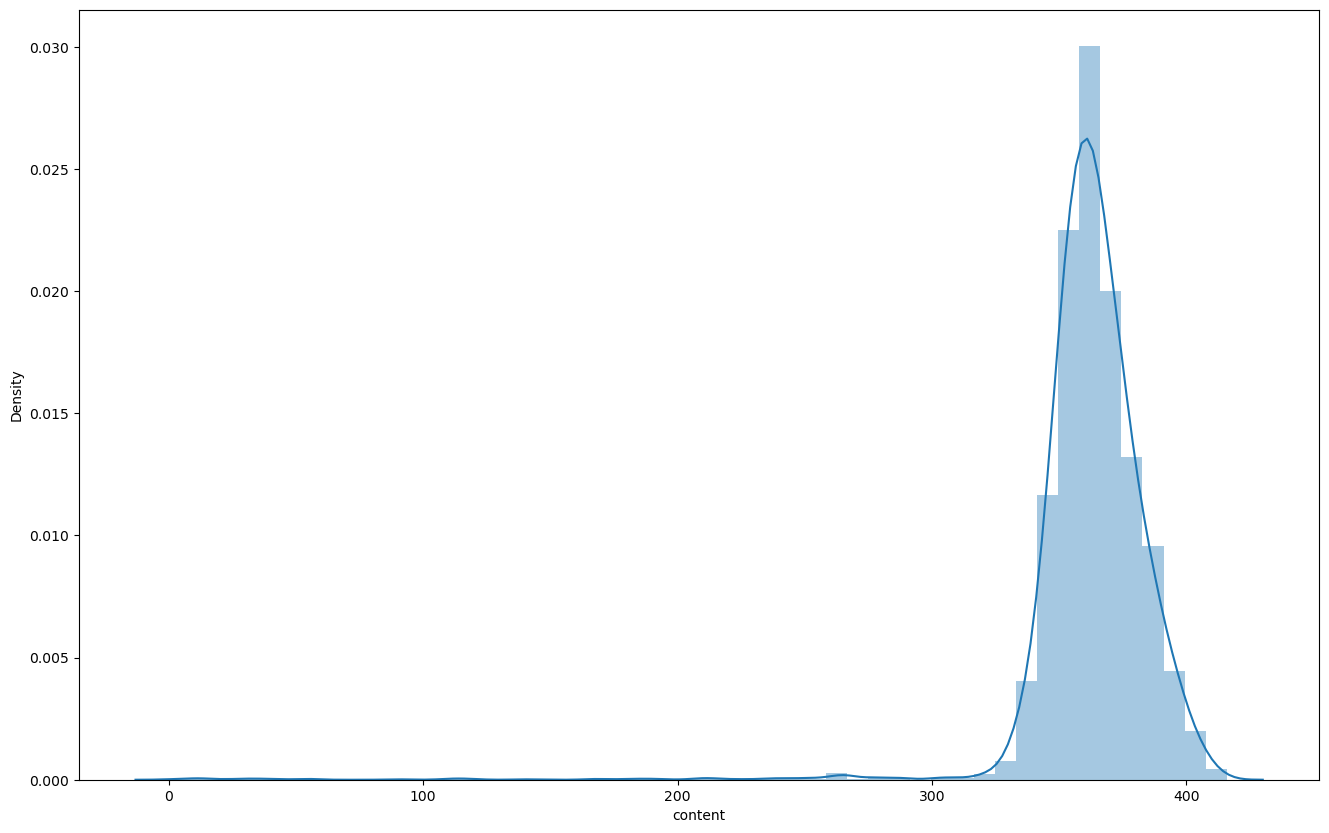

In [ ]:
# Determine the sequence length (i.e. number of words) in each row
seqlen = df['content'].apply(lambda x: len(x.split()))

plt.figure(figsize=(16, 10))
sns.distplot(seqlen)

In [ ]:
SEQ_LEN = 420

# Import tokenizer for each of the BERT models
distil_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
base_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

# Initialise empty arrays for word embeddings/tokens
distil_Xids = np.zeros((len(df), SEQ_LEN))
base_Xids = np.zeros((len(df), SEQ_LEN))
large_Xids = np.zeros((len(df), SEQ_LEN))

# Inistialise empty arrays for attention mask
distil_Xmask = np.zeros((len(df), SEQ_LEN))
base_Xmask = np.zeros((len(df), SEQ_LEN))
large_Xmask = np.zeros((len(df), SEQ_LEN))

# Loop through the rows and tokenize
## distilBERT
for i, sequence in enumerate(df['content']):
    distil_tokens = distil_tokenizer.encode_plus(sequence, max_length=SEQ_LEN,
                              truncation = True, padding='max_length',
                              add_special_tokens=True, return_token_type_ids=False,
                              return_attention_mask=True, return_tensors='tf')
    distil_Xids[i, :], distil_Xmask[i, :] = distil_tokens['input_ids'], distil_tokens['attention_mask']

## BERT-Base
for i, sequence in enumerate(df['content']):
    base_tokens = base_tokenizer.encode_plus(sequence, max_length=SEQ_LEN,
                              truncation = True, padding='max_length',
                              add_special_tokens=True, return_token_type_ids=False,
                              return_attention_mask=True, return_tensors='tf')
    base_Xids[i, :], base_Xmask[i, :] = base_tokens['input_ids'], base_tokens['attention_mask']

## BERT-Large
for i, sequence in enumerate(df['content']):
    large_tokens = large_tokenizer.encode_plus(sequence, max_length=SEQ_LEN,
                              truncation = True, padding='max_length',
                              add_special_tokens=True, return_token_type_ids=False,
                              return_attention_mask=True, return_tensors='tf')
    large_Xids[i, :], large_Xmask[i, :] = large_tokens['input_ids'], large_tokens['attention_mask']

In [ ]:
distil_Xids

array([[  101., 23142.,  2033., ...,  2014.,  1012.,   102.],
       [  101.,  4777., 20934., ...,  1040.,  2032.,   102.],
       [  101.,  1051.,  2107., ...,  2081.,  3437.,   102.],
       ...,
       [  101.,  2026., 10433., ...,  2024.,  1037.,   102.],
       [  101.,  2601., 27541., ...,  4912.,  2017.,   102.],
       [  101.,  1010.,  1996., ...,  2149.,  1010.,   102.]])

In [ ]:
distil_Xmask

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
arr = df['author_encoded'].values

labels = np.zeros((arr.size, arr.max()+1)) # +1 since it starts from 0

labels[np.arange(arr.size), arr] = 1
labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
distil_dataset = tf.data.Dataset.from_tensor_slices((distil_Xids, distil_Xmask, labels))

base_dataset = tf.data.Dataset.from_tensor_slices((base_Xids, base_Xmask, labels))

large_dataset = tf.data.Dataset.from_tensor_slices((large_Xids, large_Xmask, labels))

for i in distil_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(420,), dtype=float64, numpy=
array([  101., 23142.,  2033.,  2039.,  1037.,  2978.,  1012.,  2092.,
        1010.,  1045.,  2134.,  1005.,  1056., 29049.,  2019.,  3239.,
        1010.,  1998.,  2002., 24691.,  2098.,  1998.,  2045.,  2016.,
        2938.,  1025.,  1998.,  1045.,  5470., 23402.,  2094.,  1045.,
        2657.,  2014.,  6682.,  1011.,  1011.,  2021.,  1045.,  2876.,
        1005.,  1056.,  2074.,  8415.,  2000.,  2008.,  1012.,  1998.,
        2672.,  2016.,  2347.,  1005.,  1056.,  2061.,  4408.,  1010.,
        2295.,  2016.,  5720.,  1999.,  1037., 12831., 10178.,  1010.,
        1998.,  1045.,  2701.,  2026.,  2159.,  2412.,  2061.,  4389.,
        1010.,  2664.,  1045.,  2387.,  2014.,  2412.,  2061.,  5810.,
        1024.,  2014.,  6203.,  2210.,  9939.,  4451.,  1010.,  2014.,
       10059.,  1010., 11737., 21132.,  5413.,  1010.,  2014.,  2677.,
        2066.,  1037., 13007.,  4667.,  3123.,  1010.,  1998.,  1996.,
       25203., 21944.,  2306

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

distil_dataset = distil_dataset.map(map_func)

for i in distil_dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(420,), dtype=float64, numpy=
array([  101., 23142.,  2033.,  2039.,  1037.,  2978.,  1012.,  2092.,
        1010.,  1045.,  2134.,  1005.,  1056., 29049.,  2019.,  3239.,
        1010.,  1998.,  2002., 24691.,  2098.,  1998.,  2045.,  2016.,
        2938.,  1025.,  1998.,  1045.,  5470., 23402.,  2094.,  1045.,
        2657.,  2014.,  6682.,  1011.,  1011.,  2021.,  1045.,  2876.,
        1005.,  1056.,  2074.,  8415.,  2000.,  2008.,  1012.,  1998.,
        2672.,  2016.,  2347.,  1005.,  1056.,  2061.,  4408.,  1010.,
        2295.,  2016.,  5720.,  1999.,  1037., 12831., 10178.,  1010.,
        1998.,  1045.,  2701.,  2026.,  2159.,  2412.,  2061.,  4389.,
        1010.,  2664.,  1045.,  2387.,  2014.,  2412.,  2061.,  5810.,
        1024.,  2014.,  6203.,  2210.,  9939.,  4451.,  1010.,  2014.,
       10059.,  1010., 11737., 21132.,  5413.,  1010.,  2014.,  2677.,
        2066.,  1037., 13007.,  4667.,  3123.,  1010.,  1998.,  1996.,
       25203.,

In [ ]:
# First shuffle the dataset& set the seed
tf.random.set_seed(42)
distil_dataset = distil_dataset.shuffle(10000).batch(32)

# dataset length
DS_LEN = len(list(distil_dataset))

SPLIT = 0.89

# Assign train and validation sets for each model
distil_train = distil_dataset.take(round(DS_LEN*SPLIT))
distil_val = distil_dataset.skip(round(DS_LEN*SPLIT))

# delete dataset objects to save space
del distil_dataset

# double check the data sets have the same length and we didn't miss out any rows
print(DS_LEN)
len(distil_train)+len(distil_val)

166


166

## Model training


For each model, we fine-tuned a classifier head using ReLU activation in dense layers and a softmax activation in the output layer for author class prediction. Training used a batch size of 30, the Adam optimizer, and cross-entropy loss, with accuracy as the evaluation metric. Dropout and BatchNormalization layers had the most positive impact during fine-tuning. Models were trained for around 30 epochs, often with early stopping, and training times varied based on model architecture size.



### distilBERT fitting

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/50
148/148 [==============================] - 60s 345ms/step - loss: 0.7890 - accuracy: 0.7308 - val_loss: 1.6702 - val_accuracy: 0.4171
Epoch 2/50
148/148 [==============================] - 49s 332ms/step - loss: 0.4813 - accuracy: 0.8304 - val_loss: 0.4466 - val_accuracy: 0.8394
Epoch 3/50
148/148 [==============================] - 49s 332ms/step - loss: 0.4340 - accuracy: 0.8526 - val_loss: 0.2862 - val_accuracy: 0.9075
Epoch 4/50
148/148 [==============================] - 49s 332ms/step - loss: 0.3805 - accuracy: 0.8682 - val_loss: 0.1901 - val_accuracy: 0.9407
Epoch 5/50
148/148 [==============================] - 49s 332ms/step - loss: 0.3458 - accuracy: 0.8805 - val_loss: 0.1551 - val_accuracy: 0.9494
Epoch 6/50
148/148 [==============================] - 49s 330ms/step - loss: 0.3148 - accuracy: 0.8910 - val_loss: 0.1686 - val_accuracy: 0.9354
Epoch 7/50
148/148 [==============================] - 49s 330ms/step - loss: 0.2801 - accuracy: 0.9020 - val_loss: 0.1554 - val_ac

<Axes: title={'center': 'Accuracy'}>

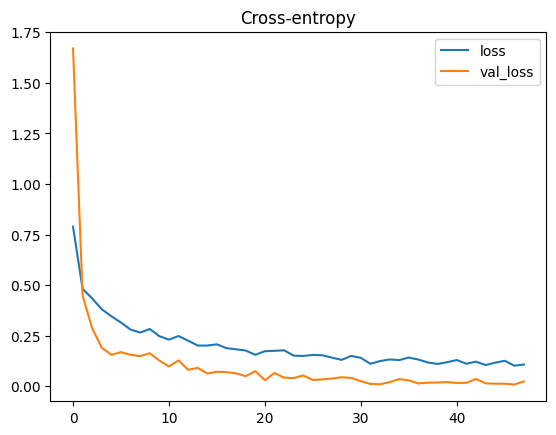

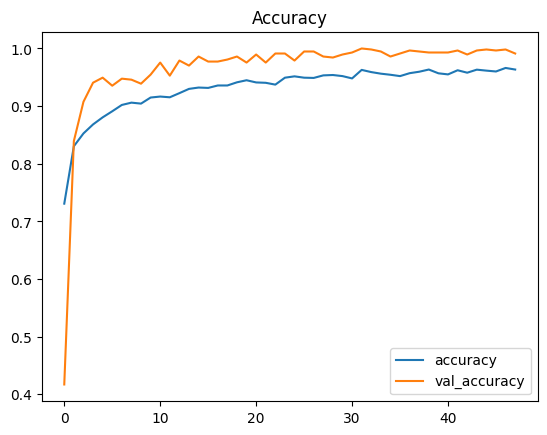

In [ ]:
# Load pre-trained DistilBERT model
from transformers import TFAutoModel
distilbert_base = TFAutoModel.from_pretrained('distilbert-base-uncased')

# Initialize random seed for reproducibility
tf.random.set_seed(42)

# Define DistilBERT input layers
distil_tokens = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
distil_mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

# Generate DistilBERT embeddings
distil_embeddings = distilbert_base(distil_tokens, attention_mask=distil_mask)[0]

# Build DistilBERT classification head with progressive dimension reduction
distil_hidden = tf.keras.layers.GlobalMaxPool1D()(distil_embeddings)
distil_hidden = tf.keras.layers.BatchNormalization()(distil_hidden)
distil_hidden = tf.keras.layers.Dense(128, activation='relu')(distil_hidden)
distil_hidden = tf.keras.layers.Dropout(0.1)(distil_hidden)
distil_hidden = tf.keras.layers.BatchNormalization()(distil_hidden)
distil_hidden = tf.keras.layers.Dense(64, activation='relu')(distil_hidden)
distil_hidden = tf.keras.layers.BatchNormalization()(distil_hidden)
distil_hidden = tf.keras.layers.Dense(32, activation='relu')(distil_hidden)
distil_predictions = tf.keras.layers.Dense(7, activation='softmax', name='outputs')(distil_hidden)

# Construct full DistilBERT model architecture
distilbert_model = tf.keras.Model(inputs=[distil_tokens, distil_mask], outputs=distil_predictions)
distilbert_model.layers[2].trainable = False  # Freeze DistilBERT weights

# Configure DistilBERT training parameters
distil_optimizer = tf.keras.optimizers.Adam(0.0001)
distil_loss = tf.keras.losses.CategoricalCrossentropy()
distil_accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

# Initialize DistilBERT with training configuration
distilbert_model.compile(optimizer=distil_optimizer, loss=distil_loss, metrics=[distil_accuracy])

# Setup early stopping callback for training
from tensorflow.keras.callbacks import EarlyStopping
distil_stopping = EarlyStopping(
    min_delta=0.001,  # Minimum improvement threshold
    patience=15,      # Epochs to wait before stopping
    restore_best_weights=True,
)

# Train the DistilBERT model
distil_history = distilbert_model.fit(
    distil_train,
    validation_data=distil_val,
    batch_size=30,
    callbacks=[distil_stopping],
    epochs=50
)

# Visualize DistilBERT training metrics
distil_results = pd.DataFrame(distil_history.history)
distil_results.loc[:, ['loss', 'val_loss']].plot(title="DistilBERT Cross-entropy")
distil_results.loc[:, ['accuracy', 'val_accuracy']].plot(title="DistilBERT Accuracy")

In [ ]:
distil_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 420)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 420)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 420, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                       

### Base BERT fitting


In [ ]:

# Delete distilBERT datasets to make sure the base BERT model doesn't use those
del distil_train
del distil_val

# Apply mapping function to structure the dataset
base_dataset = base_dataset.map(map_func)

# First shuffle the dataset& set the seed
tf.random.set_seed(42)
base_dataset = base_dataset.shuffle(10000).batch(32)

# Assign train and validation sets for each model
base_train = base_dataset.take(round(DS_LEN*SPLIT))
base_val = base_dataset.skip(round(DS_LEN*SPLIT))

# delete dataset objects to save space
del base_dataset



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/20
148/148 [==============================] - 117s 701ms/step - loss: 1.2433 - accuracy: 0.5638 - val_loss: 1.5572 - val_accuracy: 0.4223
Epoch 2/20
148/148 [==============================] - 101s 683ms/step - loss: 0.7497 - accuracy: 0.7544 - val_loss: 0.5936 - val_accuracy: 0.7923
Epoch 3/20
148/148 [==============================] - 101s 682ms/step - loss: 0.5743 - accuracy: 0.8110 - val_loss: 0.4235 - val_accuracy: 0.8517
Epoch 4/20
148/148 [==============================] - 101s 683ms/step - loss: 0.4893 - accuracy: 0.8326 - val_loss: 0.2733 - val_accuracy: 0.9058
Epoch 5/20
148/148 [==============================] - 101s 684ms/step - loss: 0.4497 - accuracy: 0.8418 - val_loss: 0.2791 - val_accuracy: 0.9040
Epoch 6/20
148/148 [==============================] - 101s 684ms/step - loss: 0.4119 - accuracy: 0.8619 - val_loss: 0.2435 - val_accuracy: 0.9215
Epoch 7/20
148/148 [==============================] - 101s 683ms/step - loss: 0.3738 - accuracy: 0.8727 - val_loss: 0.1641 -

<Axes: title={'center': 'Accuracy'}>

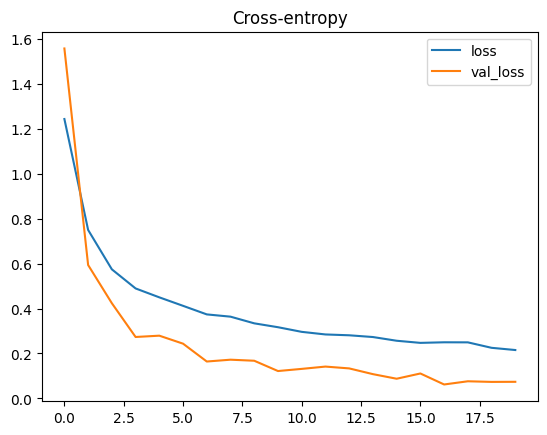

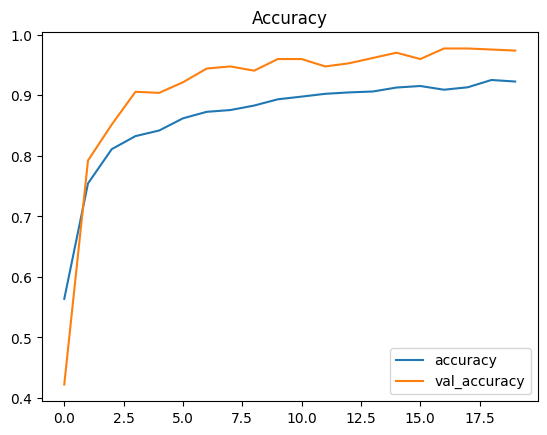

In [ ]:
# Load pre-trained BERT base model
from transformers import TFAutoModel
bert_base = TFAutoModel.from_pretrained('bert-base-uncased')

# Initialize random seed for reproducibility
tf.random.set_seed(42)

# Define BERT input layers
bert_tokens = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
bert_mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

# Generate BERT contextual embeddings
bert_embeddings = bert_base(bert_tokens, attention_mask=bert_mask)[0]

# Build BERT classification head with multi-layer architecture
bert_hidden = tf.keras.layers.GlobalMaxPool1D()(bert_embeddings)
bert_hidden = tf.keras.layers.BatchNormalization()(bert_hidden)
bert_hidden = tf.keras.layers.Dense(200, activation='relu')(bert_hidden)
bert_hidden = tf.keras.layers.Dropout(0.1)(bert_hidden)
bert_hidden = tf.keras.layers.Dense(70, activation='relu')(bert_hidden)
bert_hidden = tf.keras.layers.BatchNormalization()(bert_hidden)
bert_hidden = tf.keras.layers.Dropout(0.1)(bert_hidden)
bert_hidden = tf.keras.layers.Dense(30, activation='relu')(bert_hidden)
bert_hidden = tf.keras.layers.BatchNormalization()(bert_hidden)
bert_hidden = tf.keras.layers.Dense(30, activation='relu')(bert_hidden)  # Additional layer for training stability
bert_predictions = tf.keras.layers.Dense(7, activation='softmax', name='outputs')(bert_hidden)

# Construct full BERT model architecture
bert_model = tf.keras.Model(inputs=[bert_tokens, bert_mask], outputs=bert_predictions)
bert_model.layers[2].trainable = False  # Freeze BERT base weights

# Configure BERT training parameters
bert_optimizer = tf.keras.optimizers.Adam(0.00005)
bert_loss = tf.keras.losses.CategoricalCrossentropy()
bert_accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

# Initialize BERT with training configuration
bert_model.compile(optimizer=bert_optimizer, loss=bert_loss, metrics=[bert_accuracy])

# Train the BERT model
bert_history = bert_model.fit(
    base_train,
    validation_data=base_val,
    batch_size=30,
    epochs=50
)

# Visualize BERT training metrics
bert_results = pd.DataFrame(bert_history.history)
bert_results.loc[:, ['loss', 'val_loss']].plot(title="BERT Base Cross-entropy")
bert_results.loc[:, ['accuracy', 'val_accuracy']].plot(title="BERT Base Accuracy")

In [ ]:
# Display model summary
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 420)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 420)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 420, 7                                     

### Large BERT fitting

In [ ]:
del base_train
del base_val

# Apply mapping function to structure the dataset
large_dataset = large_dataset.map(map_func)

# First shuffle the dataset& set the seed
tf.random.set_seed(42)
large_dataset = large_dataset.shuffle(10000).batch(32)

# Assign train and validation sets for each model
large_train = large_dataset.take(round(DS_LEN*SPLIT))
large_val = large_dataset.skip(round(DS_LEN*SPLIT))

# delete dataset objects to save space
del large_dataset

# double check the data sets have the same length and we didn't miss out any rows
print(DS_LEN)
len(large_train)+len(large_val)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/50
148/148 [==============================] - 337s 2s/step - loss: 0.8596 - accuracy: 0.6907 - val_loss: 1.4111 - val_accuracy: 0.5724
Epoch 2/50
148/148 [==============================] - 305s 2s/step - loss: 0.5558 - accuracy: 0.8125 - val_loss: 0.5186 - val_accuracy: 0.8237
Epoch 3/50
148/148 [==============================] - 305s 2s/step - loss: 0.4912 - accuracy: 0.8309 - val_loss: 0.4397 - val_accuracy: 0.8517
Epoch 4/50
148/148 [==============================] - 305s 2s/step - loss: 0.4365 - accuracy: 0.8524 - val_loss: 0.5984 - val_accuracy: 0.8045
Epoch 5/50
148/148 [==============================] - 306s 2s/step - loss: 0.4237 - accuracy: 0.8577 - val_loss: 0.3073 - val_accuracy: 0.8813
Epoch 6/50
148/148 [==============================] - 305s 2s/step - loss: 0.3851 - accuracy: 0.8670 - val_loss: 0.4810 - val_accuracy: 0.8342
Epoch 7/50
148/148 [==============================] - 305s 2s/step - loss: 0.3568 - accuracy: 0.8780 - val_loss: 0.3118 - val_accuracy: 0.8918

<Axes: title={'center': 'Accuracy'}>

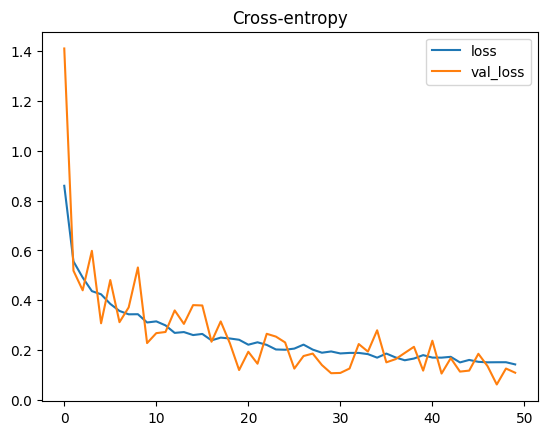

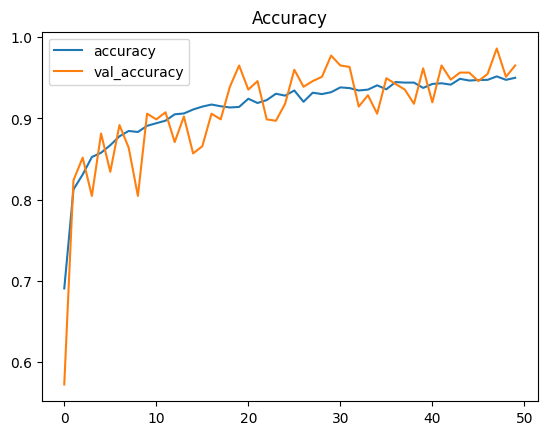

In [ ]:
# Import pretrained model
large_bert = TFAutoModel.from_pretrained('bert-large-uncased')

# Set the seed for model training
tf.random.set_seed(42)

# Define input from Xids and attention mask
input_ids = tf.keras.layers.Input(shape = (SEQ_LEN,), name = 'input_ids', dtype ='int32')
mask = tf.keras.layers.Input(shape = (SEQ_LEN,), name = 'attention_mask', dtype ='int32')

# Create embeddings
embeddings = large_bert(input_ids, attention_mask = mask)[0]

# Tuned Large BERT model layers
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dropout(rate = 0.1)(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dropout(rate = 0.1)(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)
y = tf.keras.layers.Dense(7, activation = 'softmax', name = 'outputs')(X)

large_model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

large_model.layers[2].trainable = False  # we freeze Bert parameters

# Define early stopping to prevent over-fitting
early_stopping = EarlyStopping(
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 15, # how many epochs to wait before stopping
    restore_best_weights = True,
)

# Set optimiser, loss and accuracy
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

# Compile model
large_model.compile(optimizer = optimizer, loss = loss, metrics=[acc])

history = large_model.fit(
    large_train,
    validation_data = large_val,
    batch_size = 30,
    callbacks = [early_stopping],
    epochs = 50
)

# Display loss and accuracy plots
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [ ]:
# Display model summary
large_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 420)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 420)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   3351418   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   88         'attention_mask[0][0]']      
                             hidden_state=(None, 420, 1                                     

### Weights saving and loading

In [ ]:
# Save weights after training
large_model.save_weights('large_bert_weights.h5')



In [ ]:
distil_model.save_weights('distil_bert_weights.h5')
base_model.save_weights('base_bert_weights.h5')

In [ ]:
# Resume training later
# Step 1: Recreate the model architecture
large_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# Step 2: Load the saved weights
large_model.load_weights('large_bert_weights.h5')

In [ ]:


optimizer = tf.keras.optimizers.Adam(0.00005)

# Step 3: Compile and resume training
large_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
# Define the starting epoch
initial_epoch = 50  # Replace with your desired starting epoch

history = large_model.fit(
    large_train,
    validation_data=large_val,
    batch_size=30,
    callbacks=[early_stopping],
    epochs=60,
    initial_epoch=initial_epoch
)


Epoch 51/60
148/148 [==============================] - 338s 2s/step - loss: 0.1280 - accuracy: 0.9569 - val_loss: 0.0847 - val_accuracy: 0.9756
Epoch 52/60
148/148 [==============================] - 306s 2s/step - loss: 0.1247 - accuracy: 0.9586 - val_loss: 0.0896 - val_accuracy: 0.9616
Epoch 53/60
148/148 [==============================] - 306s 2s/step - loss: 0.1272 - accuracy: 0.9584 - val_loss: 0.0844 - val_accuracy: 0.9668
Epoch 54/60
148/148 [==============================] - 306s 2s/step - loss: 0.1225 - accuracy: 0.9601 - val_loss: 0.1124 - val_accuracy: 0.9599
Epoch 55/60
148/148 [==============================] - 306s 2s/step - loss: 0.1179 - accuracy: 0.9573 - val_loss: 0.0993 - val_accuracy: 0.9703
Epoch 56/60
148/148 [==============================] - 306s 2s/step - loss: 0.1244 - accuracy: 0.9582 - val_loss: 0.1021 - val_accuracy: 0.9651
Epoch 57/60
148/148 [==============================] - 307s 2s/step - loss: 0.1170 - accuracy: 0.9580 - val_loss: 0.0680 - val_accuracy:

## Eval Metrics and Results


To generate final predictions, we encoded the hold-out test set using the appropriate tokenizer and converted it into a TensorFlow object. Predicted class labels were obtained by selecting the author with the highest probability. Model performance was then evaluated by comparing predicted labels with true labels to calculate F-1 score and other metrics.

In [ ]:
true_labels = np.array(test_set['author_encoded'])


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score

def prepare_data(text, m_tokenizer, SEQ_LEN):
    """Tokenize input text using BERT tokenizer"""
    tokens = m_tokenizer.encode_plus(
        text,
        max_length=SEQ_LEN,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_token_type_ids=False,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float32),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float32)
    }

def evaluate_model(test_set, m_model, m_tokenizer, SEQ_LEN, class_names=None):
    """
    Evaluate the model using multiple metrics

    Parameters:
    -----------
    test_set : pandas DataFrame
        Dataset containing 'content' and 'author_encoded' columns
    distil_model : tf.keras.Model
        Trained BERT model
    distil_tokenizer : transformers.PreTrainedTokenizer
        BERT tokenizer
    SEQ_LEN : int
        Maximum sequence length
    class_names : list, optional
        List of class names for the classification report

    Returns:
    --------
    dict
        Dictionary containing all evaluation metrics
    """
    # Create a list to store predicted labels
    predicted_labels = []
    predicted_probs = []

    # Iterate through the test set
    for idx, row in test_set.iterrows():
        content = row['content']
        # Prepare data
        prepared_data = prepare_data(content, m_tokenizer, SEQ_LEN)
        # Make predictions
        probs = m_model.predict(prepared_data, verbose=0)
        predicted_label = np.argmax(probs[0])
        predicted_labels.append(predicted_label)
        predicted_probs.append(probs[0])

    # Convert lists to numpy arrays
    predicted_labels = np.array(predicted_labels)
    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(test_set['author_encoded'])

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(true_labels, predicted_labels),
        'macro_f1': f1_score(true_labels, predicted_labels, average='macro'),
        'micro_f1': f1_score(true_labels, predicted_labels, average='micro'),
        'weighted_f1': f1_score(true_labels, predicted_labels, average='weighted'),
        'macro_precision': precision_score(true_labels, predicted_labels, average='macro'),
        'macro_recall': recall_score(true_labels, predicted_labels, average='macro')
    }

    # Generate and print detailed classification report
    if class_names is not None:
        report = classification_report(
            true_labels,
            predicted_labels,
            target_names=class_names,
            output_dict=True
        )
        metrics['classification_report'] = report

    # Print results
    print("\n=== LargeBERT Model Evaluation ===")
    print(f"Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Macro F1-Score: {metrics['macro_f1']*100:.2f}%")
    print(f"Micro F1-Score: {metrics['micro_f1']*100:.2f}%")
    print(f"Weighted F1-Score: {metrics['weighted_f1']*100:.2f}%")
    print(f"Macro Precision: {metrics['macro_precision']*100:.2f}%")
    print(f"Macro Recall: {metrics['macro_recall']*100:.2f}%")

    if class_names is not None:
        print("\n=== Detailed Classification Report ===")
        print(classification_report(true_labels, predicted_labels, target_names=class_names))

    return metrics, predicted_labels, predicted_probs

metrics, predictions, probabilities = evaluate_model(
     test_set,
    large_model,
    large_tokenizer,
    SEQ_LEN,
    authors
 )


=== LargeBERT Model Evaluation ===
Accuracy: 88.81%
Macro F1-Score: 88.17%
Micro F1-Score: 88.81%
Weighted F1-Score: 89.01%
Macro Precision: 88.18%
Macro Recall: 88.49%

=== Detailed Classification Report ===
                               precision    recall  f1-score   support

          Nathaniel Hawthorne       0.99      0.99      0.99        83
                Thomas Holmes       0.79      0.78      0.78        80
   L. Adams (Lily Adams) Beck       0.68      0.85      0.75        65
                  Henry James       0.94      0.96      0.95        81
          Henry Rider Haggard       0.99      0.91      0.95       120
4th century Smyrnaeus Quintus       0.92      0.89      0.91        81
          William Shakespeare       0.86      0.82      0.84        80

                     accuracy                           0.89       590
                    macro avg       0.88      0.88      0.88       590
                 weighted avg       0.90      0.89      0.89       590



In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score

def prepare_data(text, m_tokenizer, SEQ_LEN):
    """Tokenize input text using BERT tokenizer"""
    tokens = m_tokenizer.encode_plus(
        text,
        max_length=SEQ_LEN,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_token_type_ids=False,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float32),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float32)
    }

def evaluate_model(test_set, m_model, m_tokenizer, SEQ_LEN, class_names=None):
    """
    Evaluate the model using multiple metrics

    Parameters:
    -----------
    test_set : pandas DataFrame
        Dataset containing 'content' and 'author_encoded' columns
    distil_model : tf.keras.Model
        Trained BERT model
    distil_tokenizer : transformers.PreTrainedTokenizer
        BERT tokenizer
    SEQ_LEN : int
        Maximum sequence length
    class_names : list, optional
        List of class names for the classification report

    Returns:
    --------
    dict
        Dictionary containing all evaluation metrics
    """
    # Create a list to store predicted labels
    predicted_labels = []
    predicted_probs = []

    # Iterate through the test set
    for idx, row in test_set.iterrows():
        content = row['content']
        # Prepare data
        prepared_data = prepare_data(content, m_tokenizer, SEQ_LEN)
        # Make predictions
        probs = m_model.predict(prepared_data, verbose=0)
        predicted_label = np.argmax(probs[0])
        predicted_labels.append(predicted_label)
        predicted_probs.append(probs[0])

    # Convert lists to numpy arrays
    predicted_labels = np.array(predicted_labels)
    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(test_set['author_encoded'])

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(true_labels, predicted_labels),
        'macro_f1': f1_score(true_labels, predicted_labels, average='macro'),
        'micro_f1': f1_score(true_labels, predicted_labels, average='micro'),
        'weighted_f1': f1_score(true_labels, predicted_labels, average='weighted'),
        'macro_precision': precision_score(true_labels, predicted_labels, average='macro'),
        'macro_recall': recall_score(true_labels, predicted_labels, average='macro')
    }

    # Generate and print detailed classification report
    if class_names is not None:
        report = classification_report(
            true_labels,
            predicted_labels,
            target_names=class_names,
            output_dict=True
        )
        metrics['classification_report'] = report

    # Print results
    print("\n=== Base Model Evaluation ===")
    print(f"Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Macro F1-Score: {metrics['macro_f1']*100:.2f}%")
    print(f"Micro F1-Score: {metrics['micro_f1']*100:.2f}%")
    print(f"Weighted F1-Score: {metrics['weighted_f1']*100:.2f}%")
    print(f"Macro Precision: {metrics['macro_precision']*100:.2f}%")
    print(f"Macro Recall: {metrics['macro_recall']*100:.2f}%")

    if class_names is not None:
        print("\n=== Detailed Classification Report ===")
        print(classification_report(true_labels, predicted_labels, target_names=class_names))

    return metrics, predicted_labels, predicted_probs

metrics, predictions, probabilities = evaluate_model(
     test_set,
    base_model,
     base_tokenizer,
    SEQ_LEN,
    authors
 )


=== Base Model Evaluation ===
Accuracy: 87.29%
Macro F1-Score: 86.29%
Micro F1-Score: 87.29%
Weighted F1-Score: 87.53%
Macro Precision: 86.61%
Macro Recall: 86.41%

=== Detailed Classification Report ===
                               precision    recall  f1-score   support

          Nathaniel Hawthorne       0.98      0.98      0.98        83
                Thomas Holmes       0.84      0.72      0.78        80
   L. Adams (Lily Adams) Beck       0.63      0.75      0.69        65
                  Henry James       0.96      0.91      0.94        81
          Henry Rider Haggard       1.00      0.94      0.97       120
4th century Smyrnaeus Quintus       0.77      0.89      0.83        81
          William Shakespeare       0.88      0.85      0.87        80

                     accuracy                           0.87       590
                    macro avg       0.87      0.86      0.86       590
                 weighted avg       0.88      0.87      0.88       590



In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score

def prepare_data(text, distil_tokenizer, SEQ_LEN):
    """Tokenize input text using DistilBERT tokenizer"""
    tokens = distil_tokenizer.encode_plus(
        text,
        max_length=SEQ_LEN,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_token_type_ids=False,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float32),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float32)
    }

def evaluate_model(test_set, distil_model, distil_tokenizer, SEQ_LEN, class_names=None):
    """
    Evaluate the model using multiple metrics

    Parameters:
    -----------
    test_set : pandas DataFrame
        Dataset containing 'content' and 'author_encoded' columns
    distil_model : tf.keras.Model
        Trained DistilBERT model
    distil_tokenizer : transformers.PreTrainedTokenizer
        DistilBERT tokenizer
    SEQ_LEN : int
        Maximum sequence length
    class_names : list, optional
        List of class names for the classification report

    Returns:
    --------
    dict
        Dictionary containing all evaluation metrics
    """
    # Create a list to store predicted labels
    predicted_labels = []
    predicted_probs = []

    # Iterate through the test set
    for idx, row in test_set.iterrows():
        content = row['content']
        # Prepare data
        prepared_data = prepare_data(content, distil_tokenizer, SEQ_LEN)
        # Make predictions
        probs = distil_model.predict(prepared_data, verbose=0)
        predicted_label = np.argmax(probs[0])
        predicted_labels.append(predicted_label)
        predicted_probs.append(probs[0])

    # Convert lists to numpy arrays
    predicted_labels = np.array(predicted_labels)
    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(test_set['author_encoded'])

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(true_labels, predicted_labels),
        'macro_f1': f1_score(true_labels, predicted_labels, average='macro'),
        'micro_f1': f1_score(true_labels, predicted_labels, average='micro'),
        'weighted_f1': f1_score(true_labels, predicted_labels, average='weighted'),
        'macro_precision': precision_score(true_labels, predicted_labels, average='macro'),
        'macro_recall': recall_score(true_labels, predicted_labels, average='macro')
    }

    # Generate and print detailed classification report
    if class_names is not None:
        report = classification_report(
            true_labels,
            predicted_labels,
            target_names=class_names,
            output_dict=True
        )
        metrics['classification_report'] = report

    # Print results
    print("\n=== DistilBERT Model Evaluation ===")
    print(f"Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Macro F1-Score: {metrics['macro_f1']*100:.2f}%")
    print(f"Micro F1-Score: {metrics['micro_f1']*100:.2f}%")
    print(f"Weighted F1-Score: {metrics['weighted_f1']*100:.2f}%")
    print(f"Macro Precision: {metrics['macro_precision']*100:.2f}%")
    print(f"Macro Recall: {metrics['macro_recall']*100:.2f}%")

    if class_names is not None:
        print("\n=== Detailed Classification Report ===")
        print(classification_report(true_labels, predicted_labels, target_names=class_names))

    return metrics, predicted_labels, predicted_probs

metrics, predictions, probabilities = evaluate_model(
     test_set,
    distil_model,
     distil_tokenizer,
    SEQ_LEN,
    authors
 )


=== DistilBERT Model Evaluation ===
Accuracy: 85.08%
Macro F1-Score: 84.57%
Micro F1-Score: 85.08%
Weighted F1-Score: 85.86%
Macro Precision: 86.38%
Macro Recall: 84.54%

=== Detailed Classification Report ===
                               precision    recall  f1-score   support

          Nathaniel Hawthorne       1.00      0.93      0.96        83
                Thomas Holmes       0.71      0.81      0.76        80
   L. Adams (Lily Adams) Beck       0.55      0.83      0.66        65
                  Henry James       1.00      0.72      0.83        81
          Henry Rider Haggard       1.00      0.92      0.96       120
4th century Smyrnaeus Quintus       0.88      0.89      0.88        81
          William Shakespeare       0.92      0.82      0.87        80

                     accuracy                           0.85       590
                    macro avg       0.86      0.85      0.85       590
                 weighted avg       0.88      0.85      0.86       590



In [ ]:
from IPython.display import FileLink
FileLink('base_bert_weights.h5')

/kaggle/working/large_bert_weights.h5

### Visual Comparison
Our results were that LargeBERT and BERT base perform similarly well, whereas  distilBERT has a slightly lower performance at 86%.

<function matplotlib.pyplot.show(close=None, block=None)>

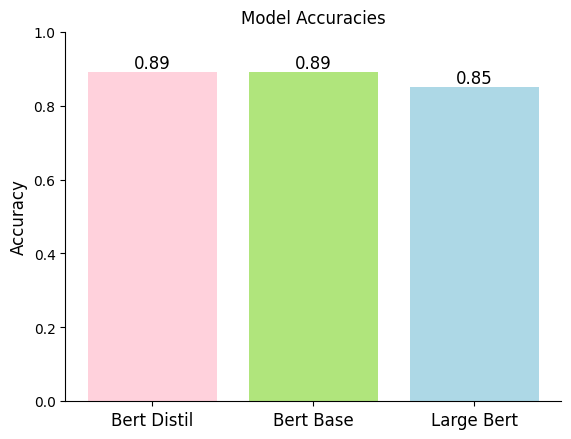

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# F-1 values
bert_base_acc = 0.89
large_bert_acc = 0.85
distil_bert_acc = 0.89

# Create data for the grouped bar chart
accuracies = np.array([distil_bert_acc, bert_base_acc, large_bert_acc])
labels = ['Bert Distil', 'Bert Base', 'Large Bert']

# Pastel colors
pastel_colors = ['#FFD1DC', '#B0E57C', '#ADD8E6']

# Plotting the bar chart with text labels
fig, ax = plt.subplots()
bars = ax.bar(labels, accuracies, color=pastel_colors)

# Adding text labels on top of the bars with larger font size
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{acc:.2f}', ha = 'center', va = 'bottom', fontsize = 12)

sns.reset_orig()
# Altering plot aesthetics
plt.xticks(fontsize = 12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Model Accuracies')
plt.ylabel('Accuracy', fontsize = 12)
plt.ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

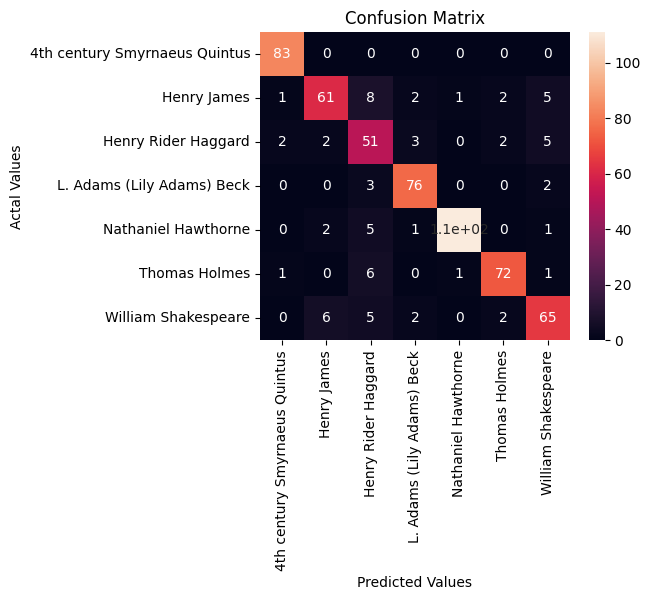

In [ ]:
# Creating a confusion matrix, which compares the y_test and y_pred
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, distil_predicted_labels)

cm_df = pd.DataFrame(cm,
                     index = ["4th century Smyrnaeus Quintus", "Henry James",
                              "Henry Rider Haggard", "L. Adams (Lily Adams) Beck",
                              "Nathaniel Hawthorne", "Thomas Holmes", "William Shakespeare"],
                     columns = ["4th century Smyrnaeus Quintus", "Henry James",
                              "Henry Rider Haggard", "L. Adams (Lily Adams) Beck",
                              "Nathaniel Hawthorne", "Thomas Holmes", "William Shakespeare"])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

authors = ["4th century Smyrnaeus Quintus", "Henry James",
           "Henry Rider Haggard", "L. Adams (Lily Adams) Beck",
           "Nathaniel Hawthorne", "Thomas Holmes", "William Shakespeare"]

plt.figure(figsize=(15, 10))

for author in authors:
    author_data = data[data['author'] == author]
    author_text = ' '.join(author_data['content'].astype(str))

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50)
    wordcloud.generate(author_text)

    plt.subplot(2, 4, authors.index(author) + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(author)

plt.show()